In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#N = 50
#origin = [0], [0]
#num_trials = 2

Observation matrix C:
[[-0.70219024  1.71811031 -0.79083077 -0.46031161  0.51641669]
 [ 0.22805188 -0.22389617  0.61615827 -0.95734984 -0.68017741]]
State evolution matrix A:
[[ 1.26837201  0.          0.          0.          0.        ]
 [ 0.         -0.08015527  0.          0.          0.        ]
 [ 0.          0.          0.59670233  0.          0.        ]
 [ 0.          0.          0.          0.22042385  0.        ]
 [ 0.          0.          0.          0.          0.28058423]]


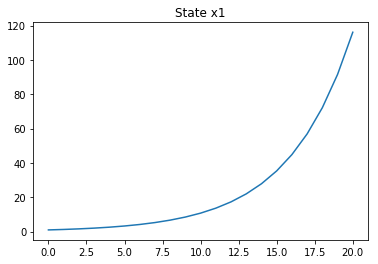

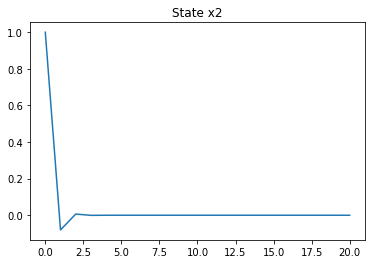

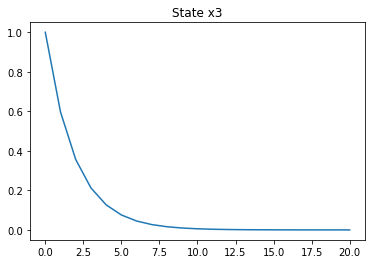

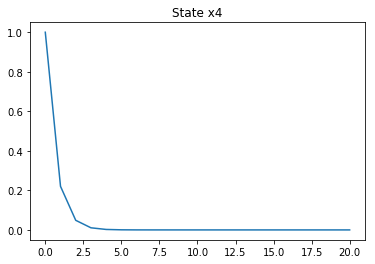

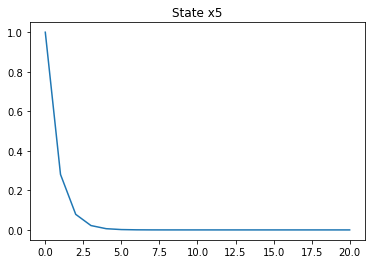

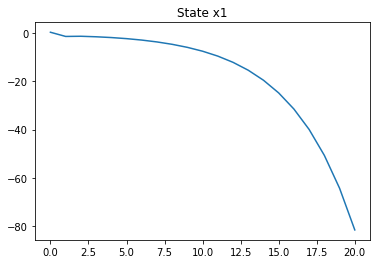

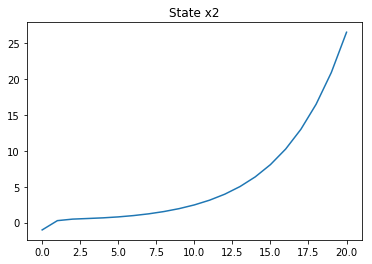

In [14]:
def choose_random_A(dim, num_largest_eig, large_eig_mean, large_eig_sigma, stable_eig_sigma):
    # Chooses a random diagonal A matrix with normally distributed eigenvalues
    # Parameters
    #  dim - size of square matrix
    #  num_largest_eig - number of largest eigenvalues
    #  large_eig_mean - mean of normal distribution of largest eigenvalues
    #  large_eig_sigma - SD of normal distribution of largest eigenavalues
    #  stable_eig_sigma - SD of normal distribution of stable eigenvalues, has mean 0
    # Output
    #  State evolution matrix A
    eig_unstable = large_eig_mean + large_eig_sigma * np.random.randn(num_largest_eig)
    num_stable_eig = dim - num_largest_eig
    eig_stable = stable_eig_sigma * np.random.randn(num_stable_eig)
    eig = np.concatenate((eig_unstable, eig_stable))
    return np.diag(eig)    
    
def simulate_free_response(A, N, x_init):
    # Simulates x[k+1] = Ax[k] + Bu
    # Parameters
    #   A - state evolution matrix
    #   x_init - initial state, numpy row vector
    #   N - time step to simulate to
    # Output
    #   State trace x - set of all states from x[0] to x[N] as row vectors
    
    # Do an input validation with the shape of u somewhere
    dim = A.shape[0]
    x = np.zeros([N + 1, dim])
    x[0,:] = x_init
    # B = np.ones([1, dim])
    for i in range(N):
        x[i+1,:] = A.dot(x[i,:])
    return x

#edit K, add feedback vector B
def plot_state_trace(x):
    # Plots each of the states of some trace x individually
    # Parameters
    #  x - state trace
    N = x.shape[0]
    dim = x.shape[1]
    for i in range(dim):
        fig, ax = plt.subplots()
        ax.plot(range(N), x[:, i])
        ax.set_title('State x{0}'.format(i+1))
    plt.show()
    
def plot_trials():
    x_trials = np.zeros([n*K, 2])
    for i in range(n):
        #x_trials[i*K:(i+1)*K,:] = simulate(u1, u2, s1, s2, K, x0, , b2);
        fig, ax=plt.subplots()
        for j in range(K):
            ax.quiver(*origin, x_trials[i*K+j,0], x_trials[i*K+j,1], color=[(K-j)/K,j/K,0], angles='xy', scale_units='xy', scale=1)
        y_max = max(abs(x_trials[i*K:(i+1)*K,1]))
        x_max = max(abs(x_trials[i*K:(i+1)*K,0]))
        ax.set_xlim([-x_max, x_max])
        ax.set_ylim([-y_max, y_max])
        plt.show()

A = choose_random_A(5, 1, 1.2, 0.05, 0.3)
C = np.random.randn(2, 5)
subspace_dim = 
while np.linalg.matrix_rank(C) < 2:
    C = np.random.randn(2, 5)
x_init = np.ones(5)
x = simulate_free_response(A, 20, x_init)
x_obs = (C.dot(x.T)).T
print("Observation matrix C:")
print(C)
print("State evolution matrix A:")
print(A)
plot_state_trace(x)
plot_state_trace(x_obs)

In [ ]:
# Old code
# plot_trials(1.2, 0.96, 0.1, 0.01, N, [2, 3], num_trials, 0, 0)
# plot_trials(1.2, -0.96, 0.1, 0.1, N, [2, 3], num_trials, -1.2, 0)
# plot_trials(-0.96, -0.96, 0.1, 0.1, 1000, [1, 1], 1, 1.96, 1.96)